In [169]:
import os

import pandas as pd 
import numpy as np

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.tree import plot_tree


In [98]:
path = '~/Desktop/CareerFoundry/3.1./'
y = pd.read_csv(os.path.join(path, 'Data/Original/Dataset-Answers-Weather_Prediction_Pleasant_Weather.csv'))
X = pd.read_pickle(os.path.join(path, 'Data/Clean/cleaned_for_keras_DATE.pkl'))

## Data Wrangling

Time period : 2010 - 2022

In [99]:
X = X[X['YEAR'].between(2010, 2022)]
y = y[y['DATE'].astype(str).str[:4].astype(int).between(2010,2022)]
X.shape, y.shape

((4687, 138), (4687, 16))

Quick checks

In [100]:
y['DATE'].astype(str).str[:4].value_counts().sort_index()

DATE
2010    365
2011    365
2012    366
2013    365
2014    365
2015    365
2016    366
2017    365
2018    365
2019    365
2020    366
2021    365
2022    304
Name: count, dtype: int64

In [101]:
X['YEAR'].value_counts().sort_index()

YEAR
2010    365
2011    365
2012    366
2013    365
2014    365
2015    365
2016    366
2017    365
2018    365
2019    365
2020    366
2021    365
2022    304
Name: count, dtype: int64

In [102]:
X.index.equals(y.index)

True

## Random Forest

Prepare data for random forest

In [127]:
X_rf = X.drop(columns=['DATE', 'YEAR', 'MONTH'], errors='ignore')

# Convert multi-label y → single binary label per day
# 1 = at least one station pleasant that day
# 0 = no stations pleasant# Convert multi-label target into single binary target

y_rf = (y.drop(columns='DATE').mean(axis=1) >= 0.3).astype(int)

pd.Series(y_rf).value_counts(normalize=True)
X_rf.shape, y_rf.shape

((4687, 135), (4687,))

In [128]:

pd.Series(y_rf).value_counts(normalize=True)

0    0.647109
1    0.352891
Name: proportion, dtype: float64

In [129]:
X_train, X_test, y_train, y_test = train_test_split(
    X_rf,
    y_rf,
    test_size=0.25,
    random_state=42,
    stratify=y_rf
)

X_train.shape, X_test.shape


((3515, 135), (1172, 135))

In [130]:
# build random forest
clf = RandomForestClassifier(
    n_estimators=100,     # number of trees
    max_depth=5,          # limit depth to avoid overfitting
    random_state=42,
    n_jobs=-1             # use all cores
)

clf

,n_estimators,100
,criterion,'gini'
,max_depth,5
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [131]:
# fit model
clf.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,5
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [132]:

y_pred = clf.predict(X_test)

accuracy = metrics.accuracy_score(y_test, y_pred)
accuracy

0.9325938566552902

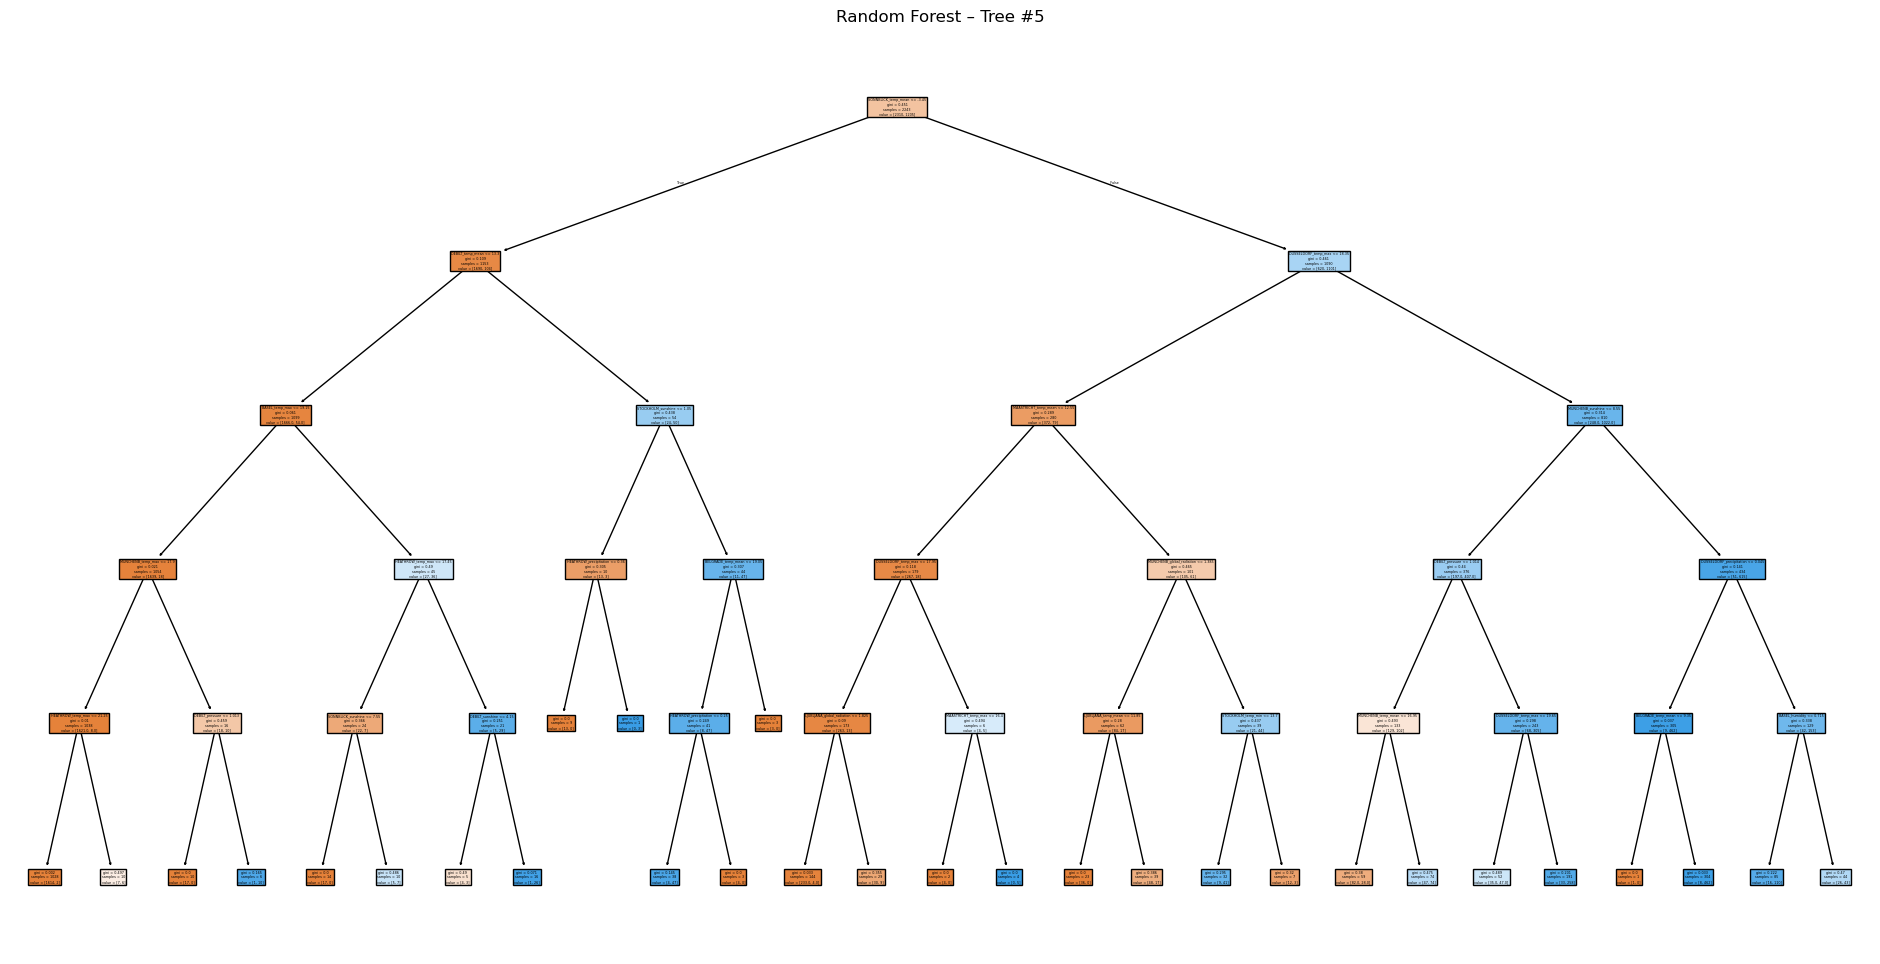

In [164]:
plt.figure(figsize=(24, 12))
plot_tree(
    clf.estimators_[5],
    feature_names=X_rf.columns,
    filled=True,
    max_depth=5
)
plt.title("Random Forest – Tree #5")
plt.show()


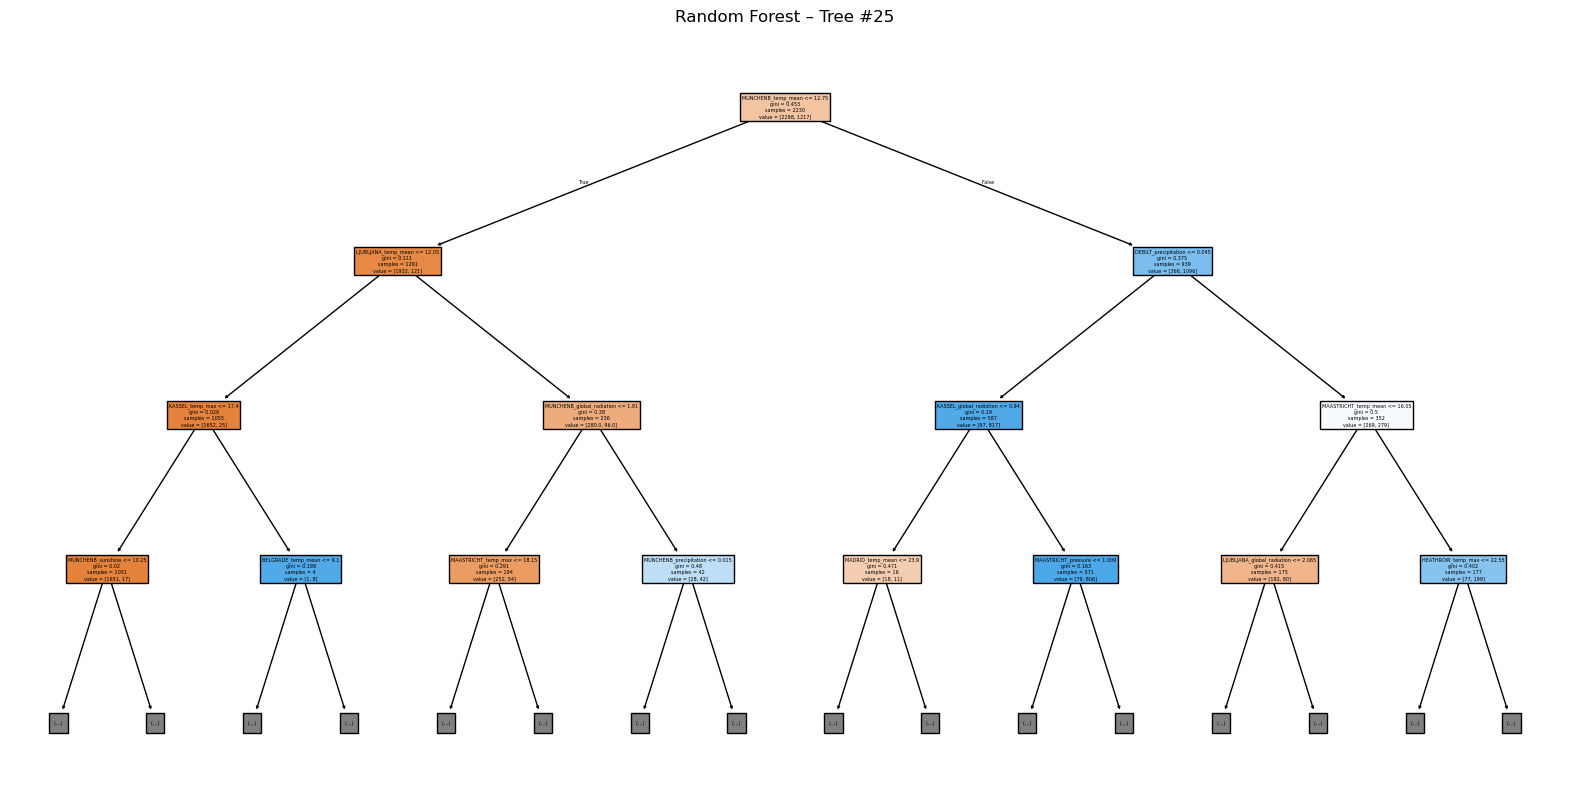

In [134]:
plt.figure(figsize=(20, 10))
plot_tree(
    clf.estimators_[25],
    feature_names=X_rf.columns,
    filled=True,
    max_depth=3
)
plt.title("Random Forest – Tree #25")
plt.show()


In [135]:
# Extract raw feature importances
importances = clf.feature_importances_

In [136]:
# Create a DataFrame for inspection
feature_importance_df = pd.DataFrame({
    'feature': X_rf.columns,
    'importance': importances
}).sort_values(by='importance', ascending=False)

feature_importance_df.head(10)

,feature,importance
44,DUSSELDORF_temp_max,0.086189
78,MAASTRICHT_temp_mean,0.076150
8,BASEL_temp_max,0.072098
98,MUNCHENB_temp_max,0.065365
80,MAASTRICHT_temp_max,0.065060
51,HEATHROW_temp_mean,0.051448
96,MUNCHENB_temp_mean,0.043606
42,DUSSELDORF_temp_mean,0.037493
6,BASEL_temp_mean,0.037341
35,DEBILT_temp_max,0.034986


In [ ]:
# sanity check
feature_importance_df['importance'].sum()


np.float64(1.0)

In [138]:
# Extract station name from feature
feature_importance_df['station'] = feature_importance_df['feature'].str.split('_').str[0]

feature_importance_df.head()

,feature,importance,station
44,DUSSELDORF_temp_max,0.086189,DUSSELDORF
78,MAASTRICHT_temp_mean,0.076150,MAASTRICHT
8,BASEL_temp_max,0.072098,BASEL
98,MUNCHENB_temp_max,0.065365,MUNCHENB
80,MAASTRICHT_temp_max,0.065060,MAASTRICHT


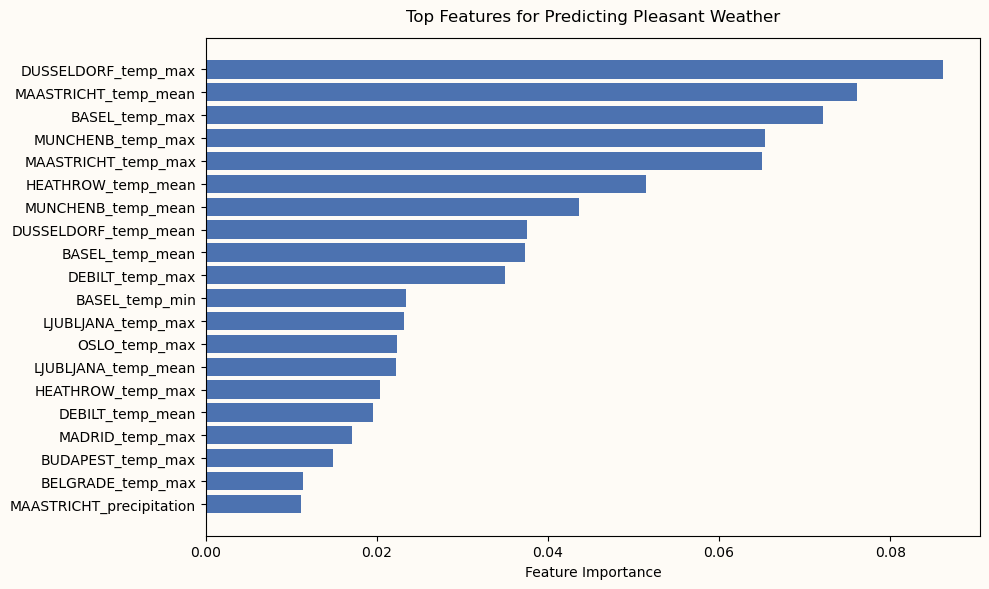

In [163]:
top_features = feature_importance_df.head(20)

fig, ax = plt.subplots(figsize=(10, 6))

# Background colors
fig.patch.set_facecolor("#FEFBF6")   
ax.set_facecolor("#FEFBF6")          
# Bar chart
ax.barh(
    top_features["feature"],
    top_features["importance"],
    color="#4C72B0" 
)

# Labels & title
ax.set_xlabel("Feature Importance")
ax.set_title(
    "Top Features for Predicting Pleasant Weather",
    pad=12
)


# Invert y-axis so most important is on top
ax.invert_yaxis()

plt.tight_layout()
plt.show()


In [155]:
# Which stations contribute most overall to predicting pleasant days?
station_importance = (
    feature_importance_df
    .groupby('station')['importance']
    .sum()
    .sort_values(ascending=False)
)

station_importance


station
MAASTRICHT    0.174395
DUSSELDORF    0.153915
BASEL         0.153592
MUNCHENB      0.133911
HEATHROW      0.083778
DEBILT        0.078225
LJUBLJANA     0.067713
OSLO          0.036537
BUDAPEST      0.024832
STOCKHOLM     0.023752
BELGRADE      0.021818
MADRID        0.020838
SONNBLICK     0.020610
KASSEL        0.005291
VALENTIA      0.000790
Name: importance, dtype: float64

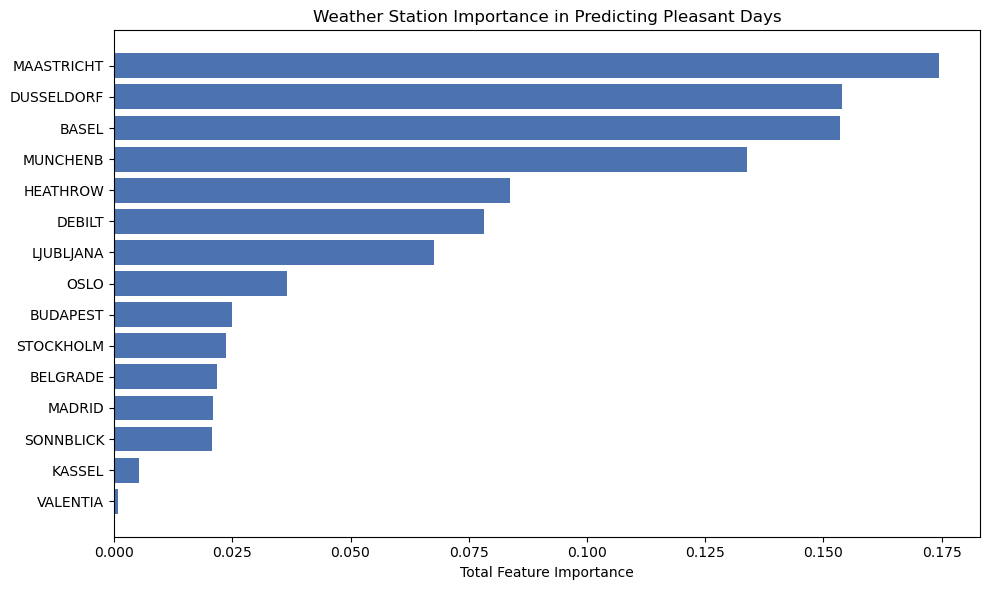

In [171]:
plt.figure(figsize=(10, 6))

# Background colors
fig.patch.set_facecolor("#FEFBF6")   
ax.set_facecolor("#FEFBF6")          

plt.barh(
    station_importance.index,
    station_importance.values,
    color="#4C72B0"
    
)

plt.xlabel("Total Feature Importance")
plt.title("Weather Station Importance in Predicting Pleasant Days")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


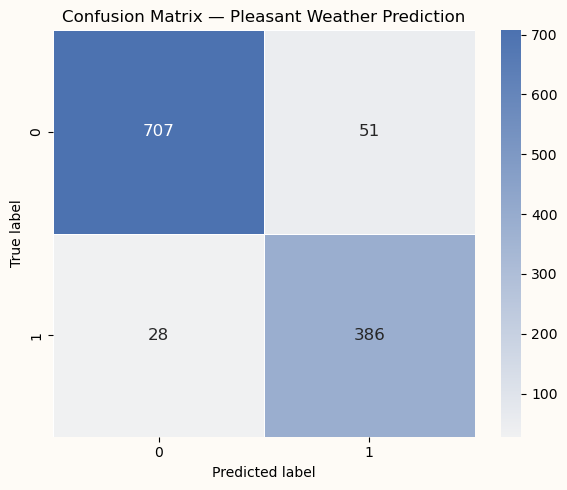

In [172]:


# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

bg_color = "#FEFBF6"     
cmap = sns.light_palette("#4C72B0", as_cmap=True)

plt.figure(figsize=(6, 5))
plt.gca().set_facecolor("#FEFBF6")
plt.gcf().patch.set_facecolor('#FEFBF6')

sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap=sns.light_palette("#4C72B0", as_cmap=True),
    cbar=True,
    linewidths=0.5,
    linecolor="white",
    annot_kws={"size": 12}
)

plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix — Pleasant Weather Prediction")

plt.tight_layout()
plt.show()
